In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from utils import ftxTransformer

In [2]:
data = pd.read_csv("ftx_PriceDataETH-PERP_1609459200_1645398000.csv")
# data = pd.read_csv("ftx_PriceDataSOL-PERP_1609459200_1645398000.csv")
# data = pd.read_csv("ftx_PriceDataLUNA-PERP_1609459200_1645398000.csv")
# data = pd.read_csv("ftx_PriceDataAVAX-PERP_1609459200_1645398000.csv")
# data = pd.read_csv("ftx_PriceDataBTC-PERP_1609459200_1645398000.csv")

data_processed = ftxTransformer(data)
data_processed

,open,high,low,close,volatility
endTime,,,,,
2021-01-01 02:00:00+00:00,735.19,750.80,734.23,749.83,NaN
2021-01-01 03:00:00+00:00,750.02,750.58,744.18,745.61,NaN
2021-01-01 04:00:00+00:00,745.61,749.45,744.78,746.75,0.005061
2021-01-01 05:00:00+00:00,746.75,748.99,741.33,744.29,0.003387
2021-01-01 06:00:00+00:00,744.29,745.09,741.40,743.12,0.002405
...,...,...,...,...,...
2022-02-20 20:00:00+00:00,2663.50,2663.50,2644.60,2650.00,0.006130
2022-02-20 21:00:00+00:00,2650.00,2651.10,2622.20,2625.50,0.006988
2022-02-20 22:00:00+00:00,2625.50,2634.20,2575.00,2599.10,0.006464


In [3]:
weeklyData = data_processed.resample('7d',offset = '8h',label='right').agg({'open':'first','close':'last','high':'max','low':'min'})
weeklyData['price_change'] = weeklyData['close'] / weeklyData['open']  - 1
weeklyData = weeklyData.dropna()
# drop this as last week data is extrapolated.
weeklyData.drop(index=weeklyData.index[-1], 
        axis=0, 
        inplace=True)
weeklyData['volatility'] = data_processed.loc[weeklyData.index,'volatility']
weeklyData.head()



,open,close,high,low,price_change,volatility
endTime,,,,,,
2021-01-01 08:00:00+00:00,735.19,741.68,750.80,734.23,0.008828,0.001471
2021-01-08 08:00:00+00:00,741.68,1176.98,1297.72,713.28,0.586911,0.025197
2021-01-15 08:00:00+00:00,1176.98,1200.70,1358.90,913.00,0.020153,0.024419
2021-01-22 08:00:00+00:00,1200.70,1163.60,1446.80,1037.80,-0.030899,0.018091
2021-01-29 08:00:00+00:00,1163.60,1304.60,1484.10,1120.00,0.121176,0.010784


In [4]:
def getFirstindex(prices,mask):
    if len(prices[mask==True])>0:
        return prices[mask].index[0]
    return None

In [5]:
# check when stop loss is hit, when profit taking is hit and when liquidation is hit. 
def checkLongExit(row, prices, factor):
    take_profit = factor[0]
    stop_loss = factor[1]
    long_liq = factor[2]
    
    take_profit_price = row.open*(1+take_profit)
    stop_loss_price = row.open*(1-stop_loss)
    liq_price = row.open*(1-long_liq)

    profit_trigger = prices.high[prices.high > take_profit_price]
    stop_trigger = prices.low[prices.low < stop_loss_price]
    
    #check which triggered first
    if (not profit_trigger.empty) & (not stop_trigger.empty):
        if profit_trigger.index.values[0] < stop_trigger.index.values[0]:
            trading_returns = interest*leverage*take_profit
            tag = 'take_profit'
        else:
            trading_returns = interest*leverage*-stop_loss
            tag = 'stop_loss'
        
    #in-between range double check if not liquidated
    elif (profit_trigger.empty) & (stop_trigger.empty):
        if row.low < liq_price:
            trading_returns = -interest
            tag = 'liquidated'
        else:
            trading_returns = interest*leverage*row.price_change #in-range long return
            tag = 'in_range'
            
    elif  not profit_trigger.empty:
        trading_returns = interest*leverage*take_profit
        tag = 'take_profit'
    elif not stop_trigger.empty:
        trading_returns = interest*leverage*-stop_loss
        tag = 'stop_loss'
        
    return trading_returns, tag


            
def checkShortExit(row, prices, factor):
    take_profit = factor[0]
    stop_loss = factor[1]
    short_liq = factor[3]
    
    take_profit_price = row.open*(1-take_profit)
    stop_loss_price = row.open*(1+stop_loss)
    liq_price = row.open*(1+short_liq)

    profit_trigger = prices.low[prices.low < take_profit_price]
    stop_trigger = prices.high[prices.high > stop_loss_price]
    
    #check which triggered first
    if (not profit_trigger.empty) & (not stop_trigger.empty):
        if profit_trigger.index.values[0] < stop_trigger.index.values[0]:
            trading_returns = interest*leverage*take_profit
            tag = 'take_profit'
        else:
            trading_returns = interest*leverage*-stop_loss
            tag = 'stop_loss'
        
    #in-range double check if not liquidated
    elif (profit_trigger.empty) & (stop_trigger.empty):
        if row.high > liq_price:
            trading_returns = -interest
            tag = 'liquidated'
        else:
            trading_returns = interest*leverage*row.price_change*-1 #in-range short return
            tag = 'in_range'
            
    elif  not profit_trigger.empty:
        trading_returns = interest*leverage*take_profit
        tag = 'take_profit'
    elif not stop_trigger.empty:
        trading_returns = interest*leverage*-stop_loss
        tag = 'stop_loss'
            
    return trading_returns, tag
  

In [6]:
def checkEntry(location,row):
    location = data_processed.index.get_loc(location)
    moving_avg = data_processed.close.iloc[location-24*3:location:24].mean() #average of previous 3 days close

    if row.close > moving_avg:
        position = 1
    else:
        position = -1
    return position

In [9]:
capital = 100
stables_yield = 0.12
leverage = 7.5
mm_min = 0.0625 #perp protocol
freq = 7 #weekly
short_liq = (1+leverage)/(leverage*(mm_min+1))-1+0.01 #adjustment from ftx high to perpV2
long_liq = 1-(1-leverage)/(leverage*(mm_min-1))-0.01 #adjustment from ftx low to perpV2

take_profit = 0.25
stop_loss = 0.05
if stop_loss > short_liq:
    print('WARNING STOP LOSS LOWER THAN LIQUIDATION')
    stop_loss = (short_liq)/1.01
  
factors = [take_profit,stop_loss,long_liq,short_liq]

position = 0
returns = 0
interest = 0
bench = capital


for i,row in weeklyData.iterrows():

    weeklyData.loc[i,'capital'] = capital
    weeklyData.loc[i,'position'] = position
    weeklyData.loc[i,'interest'] = interest
    weeklyData.loc[i,'benchmark'] = bench
    
    #have a position from previous week, calc returns
    if abs(position) > 0: 
        #get all hourly prices for the current trading week
        location = data_processed.index.get_loc(i)
        weeksPrices = data_processed[['close','high','low']].iloc[location-24*freq:location] 
        
        if position == 1:
            trading_returns, tag = checkLongExit(row, weeksPrices, factors)
        elif position == -1:
            trading_returns, tag = checkShortExit(row, weeksPrices, factors)
            
        weeklyData.loc[i,'flag'] = tag
        weeklyData.loc[i,'trading_returns'] = trading_returns*(1-0.002)
        weeklyData.loc[i,'returns'] = trading_returns + interest
        capital += trading_returns + interest
        
    #signal logic for next weeks trade
    if weeklyData.index.get_loc(i) > 0: #only starts after 1 week of accruing interest
        position = checkEntry(i,row)
    
    #interest for next weeks trade     
    interest = capital * stables_yield/365*freq 
    bench += bench*stables_yield/365*freq      
            
finalCapital = weeklyData.loc[i,'capital'] + trading_returns + interest #add last period returns and current weeks interest 






In [10]:
#results
print("trading alpha: "+str(round(weeklyData.trading_returns.sum(),3)))
print("%positive return: "+str(round(weeklyData.loc[weeklyData.trading_returns >= 0].shape[0]/weeklyData.shape[0],3)))
print("%predict accuracy: "+str(round(weeklyData.loc[weeklyData.position * weeklyData.price_change > 0].shape[0]/weeklyData.shape[0],3)))

print("\n")
print("%liq: "+str(round(weeklyData.loc[weeklyData.flag=='liquidated'].shape[0]/weeklyData.shape[0],3)))
print("%stopped: "+str(round(weeklyData.loc[weeklyData.flag=='stop_loss'].shape[0]/weeklyData.shape[0],3)))
print("\n")
print("Final Return: "+str(round(finalCapital,2)))
print("\n")
print(weeklyData.trading_returns.describe())

trading alpha: 3.119
%positive return: 0.4
%predict accuracy: 0.583


%liq: 0.0
%stopped: 0.567


Final Return: 117.56


count    58.000000
mean      0.053782
std       0.193817
min      -0.099390
25%      -0.093979
50%      -0.087261
75%       0.215126
max       0.457962
Name: trading_returns, dtype: float64


<AxesSubplot:>

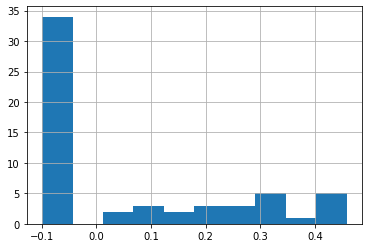

In [11]:
weeklyData.trading_returns.hist()

Text(0.5, 0, 'Time')

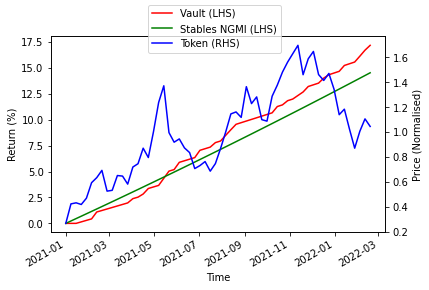

In [12]:
fig = plt.figure()
ax1 = (weeklyData.capital-100).plot(color = 'red')
(weeklyData.benchmark-100).plot(color ='green')
ax1.set_ylabel('Return (%)')
plt.twinx()
# ax2 = (plotData.close/plotData.close.iloc[0]*100).plot(color ='blue')
ax2 = (weeklyData.close/weeklyData.close.mean()).plot(color ='blue')
ax2.set_ylabel('Price (Normalised)')
fig.legend(['Vault (LHS)','Stables NGMI (LHS)','Token (RHS)'],loc='upper center')
ax1.set_xlabel('Time')